# In situ sound absorption estimation with the discrete complex image source method

In this notebook we further explore the $\textit{in situ}$ measurement of sound absorbers with array processing. Let us imagine that we can measure the sound field near a sound absorber sequentially.

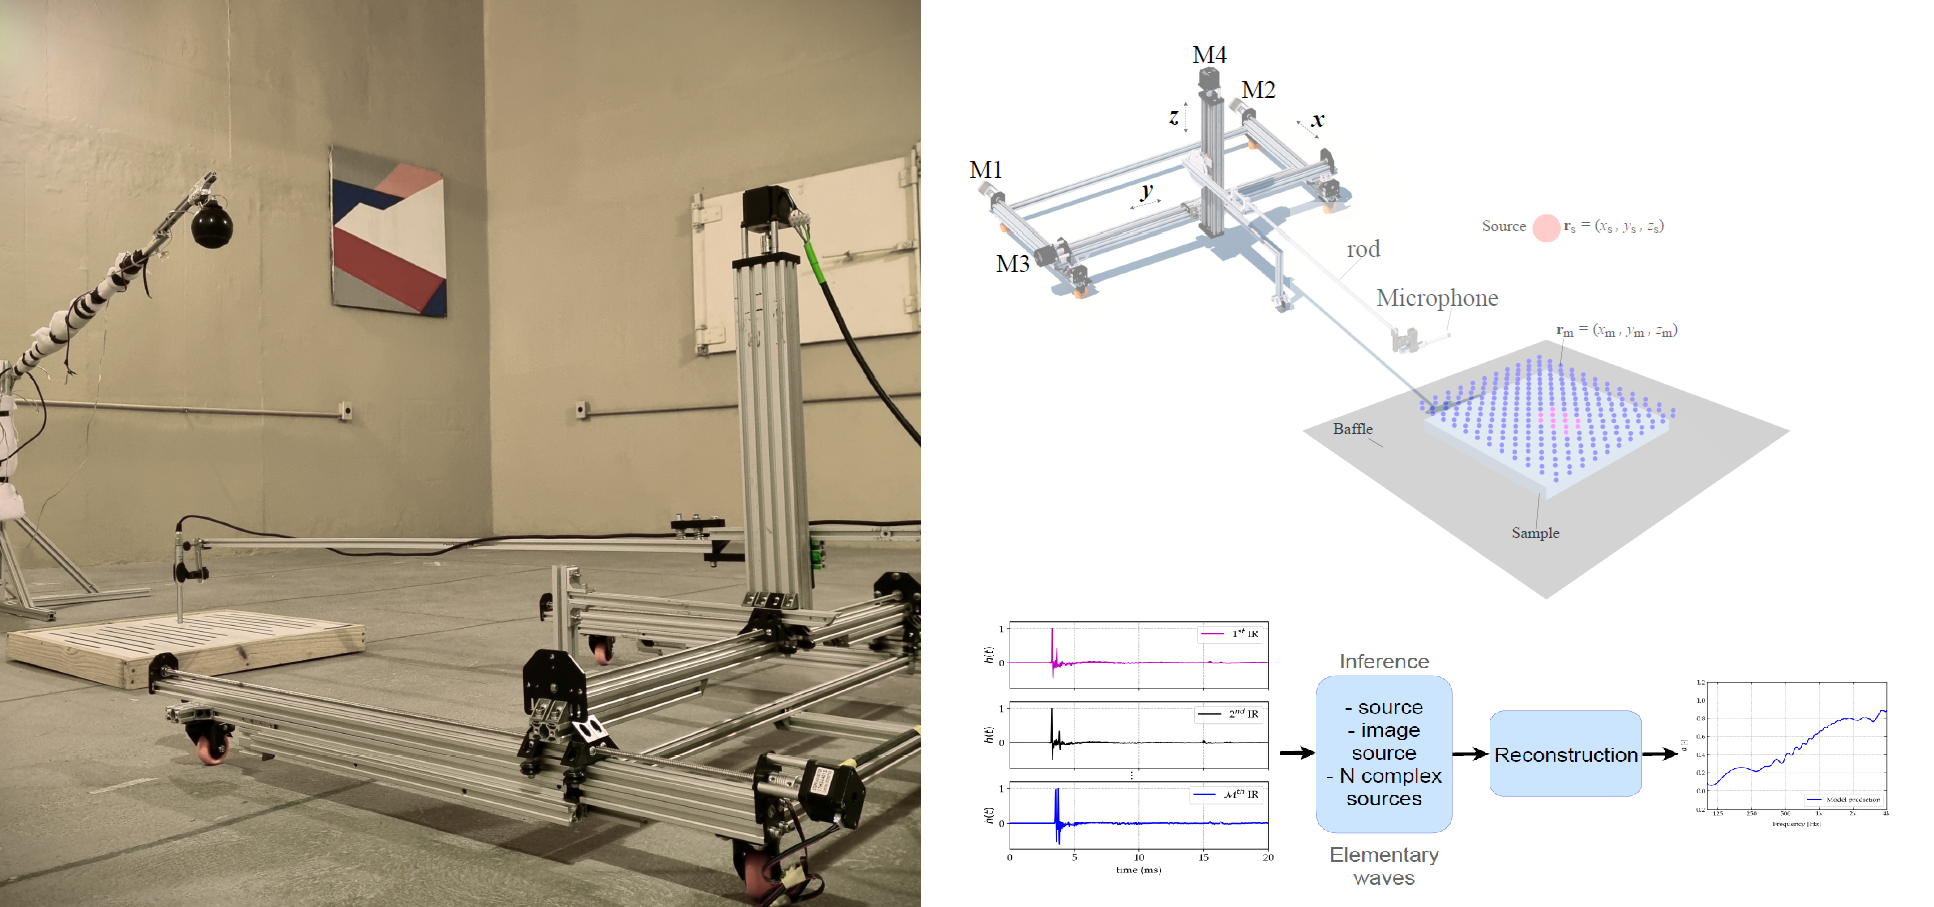

In [29]:
import numpy as np
import matplotlib.pyplot as plt # plots
plt.rcParams['axes.linewidth'] = 1
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Palatino Linotype'#'Arial' #'Palatino Linotype'
plt.rcParams['font.size'] = 12
#%matplotlib notebook

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
from controlsair import AirProperties, AlgControls, load_cfg, sph2cart
from receivers import Receiver
from field_inf_nlr import NLRInfSph  # Field Inf NLR
import utils_insitu as ut_is
import lcurve_functions as lc
from decomp_quad_v2 import Decomposition_QDT
from decomp2mono import Decomposition_2M  # Monopoles

# Discrete Complex Image Source Method (DCISM)

Real sound sources do not radiate sinle plane waves. It is much more likely that the radiation is closer to a monopole than to a plane wave. In this notebook, we explore the problem of **spherical waves** impeaging in an absorbent material. This is of relevance, specially when the **sound source is close to the material** (compact measurement system). In this case, the behaviour of the **sound field** and the **material** itself tend to be very different to what we are used to (the single plane wave incidence with constant surface impedance across the surface). 

Consider a monopole sound source radiating spherical waves near an infinite absorbing plane as in the figure below. 

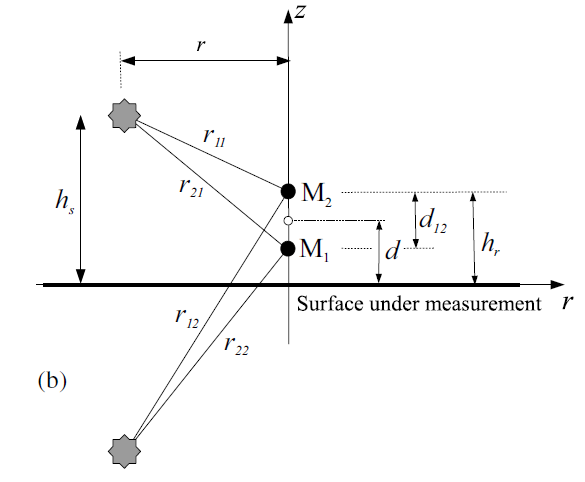

A receiver is at coordinate $\textbf{r}_{i} = (x, y, z)$. The monopole (original source) is at coordinate $\textbf{r}_{s} = (x_s, y_s, h_s)$. The image source is at coordinate $\textbf{r}^{'}_{s} = (x_s, y_s, -h_s)$. Green's functions are used to model the radiation of monopoles as

$$
\begin{align}
G(\textbf{r}_{s}, \textbf{r}_{i}) = \frac{\text{e}^{-\text{j} k_0 |\textbf{r}_{s}- \textbf{r}_{i}|}}{|\textbf{r}_{s}- \textbf{r}_{i}|}  \label{eq1}\tag{1} \\
\end{align}
$$
in which $r_{1i} = |\textbf{r}_{s}- \textbf{r}_{i}|$ is the distance between the original **source** and the $i^{th}$ receiver, and $r_{2i} = |\textbf{r}^{'}_{s}- \textbf{r}_{i}|$ is the distance between the **image source** and the $i^{th}$ receiver. Thus, one approximate model for the sound field is

$$
\begin{align}
p(\textbf{r}_{i}) = \tilde{s}_i \frac{\text{e}^{-\text{j} k_0 r_{1i}}}{r_{1i}} + \tilde{s}_r \frac{\text{e}^{-\text{j} k_0 r_{2i}}}{r_{2i}} \label{eq2}\tag{2} \\
\end{align}
$$
with $\tilde{s}_i$ being the complex amplitude of the source, and $\tilde{s}_r$ being the complex amplitude of the image source.

This is a very **simplistic** view of the problem, and similar to a plane-wave problem in an impedance tube. Spherical waves, however, do diffract in a more complicated manner, but for now, let us carry on and form an inverse problem with this simplistic model in mind.






If $\mathcal{M}$ receivers measure the sound field, a matrix equation can be writen as

$$
\begin{align}
\begin{bmatrix} p_1 \\ p_2 \\ \vdots \\ p_m \end{bmatrix} = \begin{bmatrix}  \frac{\text{e}^{-\text{j} k_0 r_{11}}}{r_{11}} & \frac{\text{e}^{-\text{j} k_0 r_{21}}}{r_{21}} \\
\frac{\text{e}^{-\text{j} k_0 r_{12}}}{r_{12}} &  \frac{\text{e}^{-\text{j} k_0 r_{22}}}{r_{22}} \\
\vdots & \vdots \\
\frac{\text{e}^{-\text{j} k_0 r_{1M}}}{r_{1M}} &  \frac{\text{e}^{-\text{j} k_0 r_{2M}}}{r_{2M}}
\end{bmatrix} \ \begin{bmatrix} \tilde{s}_i \\ \tilde{s}_r \end{bmatrix}
\end{align}
$$

or

$$
\begin{align}
\textbf{p} = \textbf{K} \textbf{s} \label{eq3}\tag{3}
\end{align}
$$

</br>
where $\textbf{p} \ \in \ \mathbb{C}^{M \times 1}$ is the measured vector of sound pressures, $\textbf{s} \ \in \ \mathbb{C}^{2 \times 1}$ is the complex amplitude vector of the source and image-source (to be determined in an inverse problem), and $\textbf{K} \ \in \ \mathbb{C}^{M \times 2}$ is the **kernel matrix** containing the Green's functions of the source and image-source.

</br>

This is one of the models implemented in Ref. [1] of this class. As said before, this is a very **simplistic** view of the problem, and similar to a plane-wave problem in an impedance tube.

[1] - Mansour Alkmim, Jacques Cuenca, Laurent De Ryck, and Wim Desmet. **Angle-dependent sound absorption estimation using a compact microphone array**, J. Acoust. Soc. Am. 150(4), October 2021. https://pubs.aip.org/asa/jasa/article/150/4/2388/993684/Angle-dependent-sound-absorption-estimation-using


# Diffraction of spherical waves

Spherical waves, do diffract in a more complicated manner, as described in Ref. [2]. We can consider that.

[2] - Xiao Di and Kenneth E. Gilbert. **An exact Laplace transform formulation for a point source
above a ground surface**, J. Acoust. Soc. Am. 93(2), February 1993. https://pubs.aip.org/asa/jasa/article/93/2/714/969914/An-exact-Laplace-transform-formulation-for-a-point


The sound field resulting from a point source above the ground has been studied by many authors. For a homogeneous atmosphere, the problem is the so-called **Sommerfeld problem**, which has a solution involving a difficult Sommerfeld integral. To evaluate the Sommerfeld integral, various assumptions and approximations have been adopted in the literature. The integral equation, without any approximation is


$$
\begin{align}
p(\textbf{r}_{i}) = \frac{\text{e}^{-\text{j} k_0 r_{1i}}}{r_{1i}} + \iint_{-\infty}^{\infty} \frac{V_p(k_{0z})}{k_{0z}}\text{e}^{-\text{j}k_{0z}(h_s + z_i)} e^{-\text{j}(k_x x + k_y y)}\text{d}k_x \text{d}k_y \label{eq4}\tag{4}
\end{align}
$$

</br>

where $k_{0z} = \sqrt{k_{0}^{2}-k_{x}^{2}-k_{y}^{2}}$, and $k_{1z} = \sqrt{k_{1}^{2}-k_{x}^{2}-k_{y}^{2}}$ are the wave-numbers in $\hat{z}$ direction on air and in the porous sample, respectively. $k_1$ is the complex wave-number of the porous sample. In fact, Eq. \eqref{eq4} is a **spatial Fourier transform**. Therfore, we can see the spherical wave-front as an infinite sum of plane waves with complex amplitudes $\frac{V_p(k_{0z})}{k_{0z}}$. The term $V_p(k_{0z})$ is the reflection coefficient of a plane wave for a given vertical wave-number (in other words, varying with the incidence angle, since a spherical wave bends continuously).

This integral is very nasty and only evaluatable after deriving a **Sommerfeld integral** and some transformations. For instance, for a porous layer over rigid backing, the integral is


\begin{equation}
\label{eq:sommer}
p(\textbf{r}_\text{m}) = \tilde{s}\left[\frac{\, \text{e}^{-\text{j} k_{0}\left|\vec{r}_{1}\right|}\,}{\left|\vec{r}_{1}\right|}
-\frac{\, \text{e}^{-\text{j} k_{0}\left|\vec{r}_{2}\right|}\,}{\left|\vec{r}_{2}\right|} 
+\int_{0}^{\infty} \! \frac{2 \, \rho_{\text{p}} \text{e}^{-\nu_{0 z}\left|z_{\text{s}}+z_{\text{m}}\right|}}{\; \nu_{0 z} \, \rho_{\text{p}}+\nu_{1 z} \, \rho_{0} \tanh \! \left(\nu_{1 z} \, d\right)} \, k \, \text{J}_{0}(k r) \text{d} k\right].
\end{equation}

</br>
with $\nu_{0 z} = \sqrt{k^{2} - k_{0}^{2}}$, and $\nu_{1 z} = \sqrt{k^{2} - k_{1}^{2}}$. For this kind of integral, you also need special numerical integration functions, which take a long time to converge. Thus, it is not suitable to an inverse problem (which may involve several evaluation passes).


# A more suitable and exact model

In contrast, we propose the use of an exact method based on an image source distribution. The reflection coefficient is expressed as a **Laplace transform over an image source function**. The final expression for the acoustic field involves a well-behaved **image-source integral** instead of the usual Sommerfeld integral. Because the integral is well behaved and convergent, it is straightforward to develop criteria for **accurate numerical evaluation of the integral**, based on **quadrature rules**, which, in turn, lead to a **discretization** suitable to form an inverse problem.


Equation \eqref{eq4} suggests that the solution above the ground can be separated into two parts: (i) the direct free-space wave from the physical source, and (ii) a **distribution** of image sources. The strength and location of each image source is to be determined.

The reflection coefficient, $V_p(k_{0z})$, can be represented by a Laplace transform,

$$
\begin{align}
V_p(k_{0z})=\int_{0}^{\infty} s(q) e^{-q k_{0 z}} \text{d} q \label{eq5}\tag{5},
\end{align}
$$


Now we substitute Eqs. \eqref{eq5} into Eq. \eqref{eq4} and perform the inverse Fourier transform with respect to $k_{x}$ and $k_{y}$. Thus, we can write


$$
\begin{align}
p(\textbf{r}_{i}) = \tilde{s}_i \frac{\text{e}^{-\text{j} k_0 r_{1i}}}{r_{1i}} + \int_{0}^{\infty} \tilde{s}(q) \ \frac{\text{e}^{-\text{j}\sqrt{r^2+(h_s + z_i -\text{j} q)^2}}}{\sqrt{r^2+(h_s + z_i -\text{j} q)^2}} \text{d}q \label{eq6}\tag{6}
\end{align}
$$

</br>
where $r = \sqrt{(x_s-x_i)^2+(y_s-x_i)^2}$ is the horizontal distance between source and the $i^{th}$ receiver. The integrand in Eq. \eqref{eq6} represents a **distribution of image sources** along a complex line (due to the $\text{j}q$ term).

Note also that the image sources contain a $\text{j}q$, which when evaluated will render a decaying exponential term as $q \rightarrow \infty$. Thus, the integral tend to be well behaved and is suitable for numerical integration, if we happen to know $s(q)$. Also, the integrand is a decaying funcion of $q$, which means that we can truncate the integral at a suitable value, $b$. These characteristics also make the integral equation suitable for discretization and to form an inverse problem.

It is also important to notice that we can modify Eq. \eqref{eq6} to 

$$
\begin{align}
p(\textbf{r}_{i}) = \tilde{s}_1 \frac{\text{e}^{-\text{j} k_0 r_{1i}}}{r_{1i}} + \tilde{s}_2 \frac{\text{e}^{-\text{j} k_0 r_{2i}}}{r_{2i}} + \int_{0^{+}}^{\infty} \tilde{s}(q) \ \frac{\text{e}^{-\text{j}\sqrt{r^2+(h_s + z_i -\text{j} q)^2}}}{\sqrt{r^2+(h_s + z_i -\text{j} q)^2}} \text{d}q \label{eq7}\tag{7}
\end{align}
$$

This approach makes sure that we include an image source, associated with the zero on the bottom limit of the integral. This helps to stabilize the solution of the inverse problem and is a key aspect. Looking at Eqs. (25) and (27) of Ref. [2] allows us to see that this is a wise assumption.

# Quadrature rules

In numerical analysis, an $N$-point Gaussian quadrature rule, named after Carl Friedrich Gauss, is a rule constructed to yield an exact integration for polynomials of degree $2N − 1$ or less by a suitable choice of the nodes $\xi_i$ and weights $w_i$ for $i = 1, ..., N$. Gaussian quadrature rules are based on evaluating suitable polynomials (that forms an orthogonal basis). 

For a function, $f(x)$, integrated from $-1$ to $1$, the Gaussian quadrature rule is stated as



$$
\begin{align}
\int_{-1}^{1} f(x) \text{d}x = \sum\limits_{i=1}^{N} w_i f(\xi_i) \label{eq8}\tag{8}
\end{align}
$$
with $w_i$ and $\xi_i$ computed (tabled) for a given order $N$.

We can change the integration dommain and write

$$
\begin{align}
\int_{a}^{b} f(x) \text{d}x = \frac{b-a}{2} \sum\limits_{i=1}^{N} w_i f\left(\frac{b-a}{2}\xi_i + \frac{b-a}{2}\right) \label{eq9}\tag{9}
\end{align}
$$


</br>

#### 1. The Gauss-Legendre quadrature uses the roots, $\xi_i$, of **Legendre polynomials** to evaluate the integrand. 
</br>

#### 2.  Another possibility is to sample the space from $-1$ to $+1$ at $N$ $\xi_i$ mid-points (evenly spaced from $-1+2/N$ to $+1-2/N$ - **mid-point rule**). 

</br>


#### 3. We can also try Gauss-Laguerre quadrature for integrands like



$$
\begin{align}
\int_{0}^{\infty} g(x) \text{e}^{-x} \text{d}x = \sum\limits_{i=1}^{N} w_i g(\xi_i) \label{eq10}\tag{10}
\end{align}
$$

This has the advantage of dealing with the integration interval automatically, but since the integrand must be of type $g(x) \text{e}^{-x}$, the general integrand $f(x)$ must be transformed to $f(x) \text{e}^{+x}$. The increasing exponential is supposed to be compensated by the decreasing term in Eq. \eqref{eq7}, as long as the order $N$ is kept in check.

# Discretization with Gaussian Quadrature

We can now include some quadrature rule in Eq. \eqref{eq7}. Let's do it for Gauss-Legendre, but the rationalle is the same for other rules. Let us write $\xi_{i}^{'} = \frac{b-a}{2}\xi_i + \frac{b-a}{2}$. Thus, Eq. \eqref{eq7} is approximated as

$$
\begin{align}
p(\textbf{r}_{i}) = \tilde{s}_1 \frac{\text{e}^{-\text{j} k_0 r_{1i}}}{r_{1i}} + \tilde{s}_2 \frac{\text{e}^{-\text{j} k_0 r_{2i}}}{r_{2i}} + \frac{b-a}{2} \sum\limits_{i = 1}^{N} \tilde{s}(\xi_{i}^{'}) \ K(r_{s-i},\xi_{i}^{'}) \label{eq11}\tag{11}
\end{align}
$$
with $\tilde{s}(\xi_{i}^{'})$ being the complex amplitude of the image source and

$$
\begin{align}
K(r_{\xi_{i}^{'}-i},\xi_{i}^{'}) = \frac{\text{e}^{-\text{j}\sqrt{r^2+(h_s + z_i -\text{j} \xi_{i}^{'})^2}}}{\sqrt{r^2+(h_s + z_i -\text{j} \xi_{i}^{'})^2}} \label{eq12}\tag{12}
\end{align}
$$
being the Green's function **kernel** between the **complex image source** and receiver. We can write a matrix equation of the follwoing form

$$
\begin{align}
\begin{bmatrix} p_1 \\ p_2 \\ \vdots \\ p_m \end{bmatrix} = \begin{bmatrix}  \frac{\text{e}^{-\text{j} k_0 r_{11}}}{r_{11}} & \frac{\text{e}^{-\text{j} k_0 r_{21}}}{r_{21}} & \frac{b-a}{2} w_1 K(r_{\xi_{1}^{'}-1},\xi_{1}^{'}) &  \frac{b-a}{2} w_2 K(r_{\xi_{2}^{'}-1},\xi_{2}^{'}) & \cdots &  \frac{b-a}{2} w_N K(r_{\xi_{N}^{'}-1},\xi_{N}^{'})\\
\frac{\text{e}^{-\text{j} k_0 r_{12}}}{r_{12}} &  \frac{\text{e}^{-\text{j} k_0 r_{22}}}{r_{22}}  & \frac{b-a}{2} w_1 K(r_{\xi_{1}^{'}-2},\xi_{1}^{'}) &  \frac{b-a}{2} w_2 K(r_{\xi_{2}^{'}-2},\xi_{2}^{'}) & \cdots &  \frac{b-a}{2} w_N K(r_{\xi_{N}^{'}-2},\xi_{N}^{'}) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
\frac{\text{e}^{-\text{j} k_0 r_{1M}}}{r_{1M}} &  \frac{\text{e}^{-\text{j} k_0 r_{2M}}}{r_{2M}} & \frac{b-a}{2} w_1 K(r_{\xi_{1}^{'}-M},\xi_{1}^{'}) &  \frac{b-a}{2} w_2 K(r_{\xi_{2}^{'}-M},\xi_{2}^{'}) & \cdots &  \frac{b-a}{2} w_N K(r_{\xi_{N}^{'}-M},\xi_{N}^{'})
\end{bmatrix} \ \begin{bmatrix} \tilde{s}_i \\ \tilde{s}_r \\ \tilde{s}_{\xi_{1}^{'}} \\ \tilde{s}_{\xi_{2}^{'}} \\ \vdots \\ \tilde{s}_{\xi_{N}^{'}} \end{bmatrix}
\end{align}
$$

</br>
where $\textbf{p} \ \in \ \mathbb{C}^{\mathcal{M} \times 1}$ is the measured vector of sound pressures, $\textbf{s} \ \in \ \mathbb{C}^{(2+N) \times 1}$ is the complex amplitude vector (to be determined in an inverse problem) and $\textbf{K} \ \in \ \mathbb{C}^{\mathcal{M} \times (2+N)}$ is the **kernel matrix** containing the Green's functions of the source, image-source and complex image sources.



# Toy problem

We will use a version of Eq. ([4](#mjx-eqn-eq4)) to compute the sound field above a layer of porous material of thickness $d$. The sample is considered to infinite in $x$ and $y$. An schematic is given in the Figure below. 

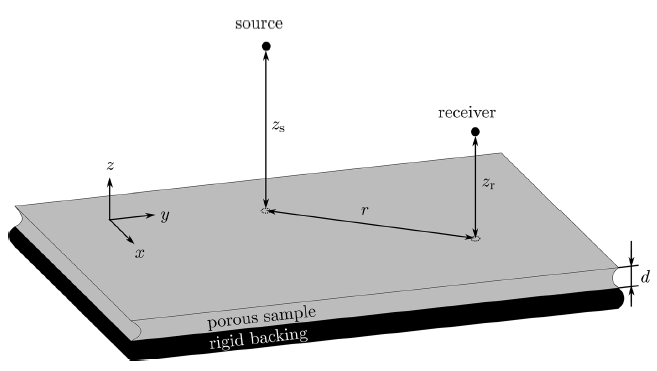

The reflection coefficient (in the integral) is given by
$$
\begin{align}
V_p(k_{0z}) = \frac{\frac{\text{j} k_{0z}}{\rho_0}-\frac{k_{1z}}{\rho_1}\text{tan}(k_{1z} d)}{\frac{\text{j} k_{0z}}{\rho_0}+\frac{k_{1z}}{\rho_1}\text{tan}(k_{1z} d)} \label{eq13}\tag{13}
\end{align}
$$

The tangent function makes the integrand have a lot of singularities. Thus, even numerical integration can be difficult (special numerical integration is used). 

**OBS:** It is important to notice that with a spherical wave impinging on the material, the **field** surface impedance differs from what would be the surface impedance of a **single** plane-wave incidence

Anyhow, we manage to compute this for:

- a random array of 128 receivers close to the surface of the porous material
- a set of points on the surface of the sample (to compare the field surface impedance (ref.) with the reconstructed surface impedance). There are $21 \times 21$ (441) points on a square of $10 \times 10$ cm, centered at $(0, 0, 0)$. Usually the reconstructed surface impedance is the spatial average of such a set of points.

Only normal incidence is considered. The sound source is at $(0, 0, h_s = 0.3)$ m (close range).

The samples may have flow resistivities of 5 kNsm$^{-4}$, 14 kNsm$^{-4}$, and 50 kNsm$^{-4}$ (ranging from very non-locally reacting to slighly locally reacting), and thicknesses of 5 cm or 10 cm.

In [83]:
main_folder = 'D:/Work/UFSM/Disciplinas/Problemas Inversos/10_DCISM/saved_fields/'

thick = 5
res = 5
theta = 0 # normal incidence

## Load field surface impedance case

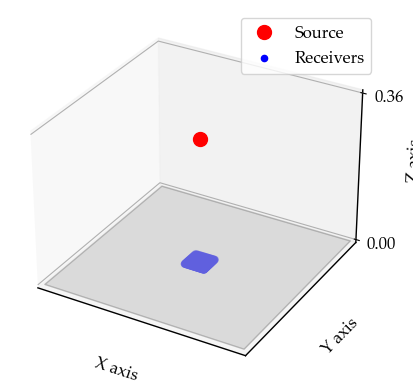

In [84]:
f_name_field_nlr_zs = 'NLR_zs_d' + str(int(thick)) +'cm_el0d_az0d_r30cm_resist' + str(int(res)) + 'k_z__0'

field_nlr_zs = NLRInfSph()  # NLR field
field_nlr_zs.load(path=main_folder, filename=f_name_field_nlr_zs)

# Plot scene 
field_nlr_zs.plot_scene(vsam_size = 1)

# Compute average $Zs$ and absorption coef.

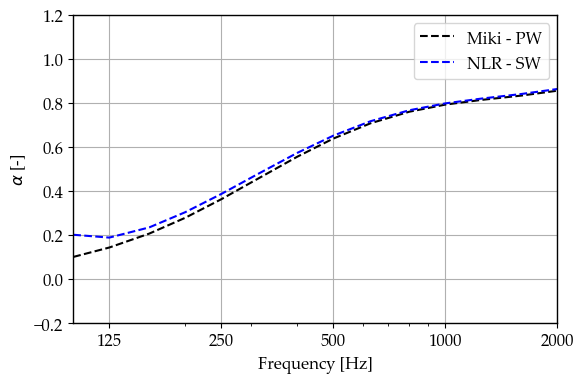

In [85]:
zs_nlr = field_nlr_zs.pres_s[0]/field_nlr_zs.uz_s[0]  # Zs = P / U
zs_nlr_mean = np.zeros(len(field_nlr_zs.controls.freq), dtype=complex)  # Mean of Zs
alpha_nlr = np.zeros(len(field_nlr_zs.controls.freq))  # Absorption coefficient

for jf in range(0, len(field_nlr_zs.controls.freq)):  # Absorption coefficient estimation
    zs_nlr_mean[jf] = np.mean(zs_nlr[:, jf])
    alpha_nlr[jf] = 1 - (np.abs(np.divide((zs_nlr_mean[jf] * np.cos(theta) - 1),
                                          (zs_nlr_mean[jf] * np.cos(theta) + 1)))) ** 2
    
plt.figure(figsize = (6,4))
plt.semilogx(field_nlr_zs.controls.freq, field_nlr_zs.material.alpha, '--k', label = 'Miki - PW')
plt.semilogx(field_nlr_zs.controls.freq, alpha_nlr, '--b', label = 'NLR - SW')
plt.legend()
plt.xticks(ticks = [125,250,500,1000,2000,4000], labels = ['125','250','500','1000','2000', '4000'], rotation = 0)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\alpha$ [-]')
plt.grid()
plt.xlim((100, 2000))
plt.ylim((-0.2, 1.2))
plt.tight_layout()

## Load the array case for inverse problem

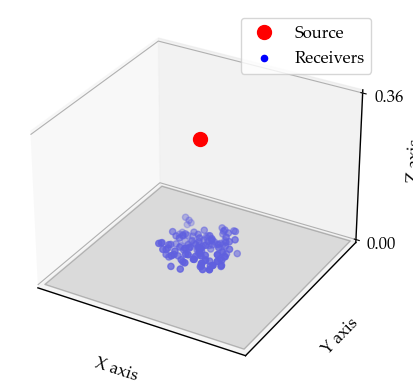

In [86]:
f_name_field_nlr = 'NLR_Inf_d' + str(int(thick)) + 'cm_el0d_az0d_r30cm_resist' + str(int(res)) + 'k_r3d_128_mics_30x30x5cm'
# Load
field_nlr = NLRInfSph()  # NLR field
field_nlr.load(path=main_folder, filename=f_name_field_nlr)
# add noise
snr = 40
field_nlr.add_noise(snr=snr, uncorr=False)  # array

# Plot scene 
field_nlr.plot_scene(vsam_size = 1)

In [87]:
print("Source coords: {}".format(field_nlr.sources.coord[0]))
print("Shape of frequencies: {}".format(field_nlr.controls.freq.shape))
print("Shape of receivers (array): {}".format(field_nlr.receivers.coord.shape))
print("Shape of sound pressure (array): {}".format(field_nlr.pres_s[0].shape))
print("Shape of receivers (Zs): {}".format(field_nlr_zs.receivers.coord.shape))

Source coords: [1.8369702e-17 0.0000000e+00 3.0000000e-01]
Shape of frequencies: (14,)
Shape of receivers (array): (128, 3)
Shape of sound pressure (array): (128, 14)
Shape of receivers (Zs): (441, 3)


# Set problem from scratch

1. You have $M$ measurements at coordinates $\textbf{r}_1, \cdots, \textbf{r}_M$;

2. Thus, you have the problem matrix:

$$
\begin{align}
\textbf{K} = \begin{bmatrix}  \frac{\text{e}^{-\text{j} k_0 r_{11}}}{r_{11}} & \frac{\text{e}^{-\text{j} k_0 r_{21}}}{r_{21}} & \frac{b-a}{2} w_1 K(r_{\xi_{1}^{'}-1},\xi_{1}^{'}) &  \frac{b-a}{2} w_2 K(r_{\xi_{2}^{'}-1},\xi_{2}^{'}) & \cdots &  \frac{b-a}{2} w_N K(r_{\xi_{N}^{'}-1},\xi_{N}^{'})\\
\frac{\text{e}^{-\text{j} k_0 r_{12}}}{r_{12}} &  \frac{\text{e}^{-\text{j} k_0 r_{22}}}{r_{22}}  & \frac{b-a}{2} w_1 K(r_{\xi_{1}^{'}-2},\xi_{1}^{'}) &  \frac{b-a}{2} w_2 K(r_{\xi_{2}^{'}-2},\xi_{2}^{'}) & \cdots &  \frac{b-a}{2} w_N K(r_{\xi_{N}^{'}-2},\xi_{N}^{'}) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
\frac{\text{e}^{-\text{j} k_0 r_{1M}}}{r_{1M}} &  \frac{\text{e}^{-\text{j} k_0 r_{2M}}}{r_{2M}} & \frac{b-a}{2} w_1 K(r_{\xi_{1}^{'}-M},\xi_{1}^{'}) &  \frac{b-a}{2} w_2 K(r_{\xi_{2}^{'}-M},\xi_{2}^{'}) & \cdots &  \frac{b-a}{2} w_N K(r_{\xi_{N}^{'}-M},\xi_{N}^{'})
\end{bmatrix} 
\end{align}
$$

You can either have an over-determined or an under-determined system of equations. This depends on: (i) the relation $N+2$ (Gauss order $+$ source and image source) vs. $\mathcal{M}$; (ii) redundancies in the kernel matrix.

4. Compute the SVD da matriz $\textbf{K} = \textbf{U}\Sigma\textbf{V}^T$
5. Use the SVD and the vector of measured pressure, $\textbf{p}$, to compute the regularization parameter, $\lambda$.
6. Compute the regularized solution

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

or you can try to

6. compute the least-squares solution

7. Reconstruction and analysis

In [88]:
# Basic set up
num_gauss_pts = 25 # Gauss order
a = 0 # lower limit of integral (always zero usually - we left it open for tests)
b = 30 # upper limit of integral (truncation)

In [89]:
# Choose frequency and check data
idf = 10
pres = field_nlr.pres_s[0][:,idf]
k0 = field_nlr.controls.k0[idf]

print(r'k0 = {0:.2f} rad/m'.format(k0))
print('shape of receiver matrix: {}'.format(field_nlr.receivers.coord.shape))
print('shape of p: {}'.format(pres.shape))

k0 = 18.32 rad/m
shape of receiver matrix: (128, 3)
shape of p: (128,)


```python
def gauss_legendre_sampling(self,):
        """ Compute roots and weights of Gauss-Legendre quadrature
        """
        # Initialize variables
        self.roots, self.weights = roots_legendre(self.quad_order)  # roots and weights of G-L polynomials
        self.q = ((self.b - self.a) / 2) * self.roots + ((self.a + self.b) / 2)  # variable interval change
```

In [90]:
# Instatiate to use class methods
decomp = Decomposition_QDT(p_mtx = pres, receivers=field_nlr.receivers, 
    source_coord=field_nlr.sources.coord[0], quad_order = num_gauss_pts, a = a, b = b, 
    retraction = 0, image_source_on = True)

# Choose sampling scheme
decomp.gauss_legendre_sampling()

print('shape of q complex sources: {}'.format(decomp.q.shape))
print('Roots shape: {}'.format(decomp.roots.shape))
print('Roots values: {}'.format(decomp.roots))

print('Weights shape: {}'.format(decomp.weights.shape))
print('Weights values: {}'.format(decomp.weights))

You choose L-curve to find optimal regularization parameter
shape of q complex sources: (25,)
Roots shape: (25,)
Roots values: [-0.99555697 -0.97666392 -0.94297457 -0.894992   -0.83344263 -0.75925926
 -0.67356637 -0.57766293 -0.47300273 -0.36117231 -0.24386688 -0.12286469
  0.          0.12286469  0.24386688  0.36117231  0.47300273  0.57766293
  0.67356637  0.75925926  0.83344263  0.894992    0.94297457  0.97666392
  0.99555697]
Weights shape: (25,)
Weights values: [0.0113938  0.02635499 0.04093916 0.0549047  0.06803833 0.0801407
 0.09102826 0.10053595 0.10851962 0.11485826 0.11945576 0.12224244
 0.12317605 0.12224244 0.11945576 0.11485826 0.10851962 0.10053595
 0.09102826 0.0801407  0.06803833 0.0549047  0.04093916 0.02635499
 0.0113938 ]


```python
def get_rec_parameters(self, receivers):
        """ Get receiver parameters
        
        Compute important receiver parameters such as source height, horizontal distance, etc
        """
        
        r = ((self.source_coord[0] - receivers.coord[:,0]) ** 2 +\
             (self.source_coord[1] - receivers.coord[:,1]) ** 2) ** 0.5  # Horizontal distance (S-R)
        zr = receivers.coord[:,2]  # Receiver height
        r1 = (r ** 2 + (self.hs - zr) ** 2) ** 0.5  # Euclidean dist. related to the real source
        r2 = (r ** 2 + (self.hs + zr) ** 2) ** 0.5  # Euclidean dist. related to the image source
        
        rq = np.zeros((receivers.coord.shape[0], self.quad_order), dtype = complex)
        hz_q = np.zeros((receivers.coord.shape[0], self.quad_order), dtype = complex)  # image source height
        for jrec, r_coord in enumerate(receivers.coord):
            rq[jrec,:] = (r[jrec] ** 2 + (self.hs + zr[jrec] - 1j * self.q) ** 2) ** 0.5 # Euclidean dist. image sources
            hz_q[jrec,:] = self.hs + zr[jrec] - 1j * self.q  # image source height
        return r, zr, r1, r2, rq, hz_q
```

In [91]:
# Get receiver data (frequency independent)
r, zr, r1, r2, rq, _ = decomp.get_rec_parameters(decomp.receivers) # r, zr, and r1 are vectors (M), rq is a M x (ng) matrix
# Get weights matrix (frequency independent)
weights_mtx = np.repeat(np.array([decomp.weights]), decomp.receivers.coord.shape[0], axis = 0) #M x (ng)
compensation_mtx = np.repeat(np.array([decomp.compensation]), decomp.receivers.coord.shape[0], axis = 0)

print(r'Shape of r1: {} / Shape of r2: {}'.format(r1.shape, r2.shape))
print('Shape of matrix with complex distances: {}'.format(rq.shape))

Shape of r1: (128,) / Shape of r2: (128,)
Shape of matrix with complex distances: (128, 25)


- Note that $\textbf{K} \ \in \mathcal{C}^{\mathcal{M} \times (2+N)}$ 


```python

    def kernel_p(self, k0, rq):  # pressure kernel function
        iq = (np.exp(-1j * k0 * rq)) / rq
        return iq
    
    def build_hmtx_p(self, shape_h, k0, r1, r2, rq, weights_mtx, compensation_mtx):
        """ build h_mtx for pressure
        Parameters
        ----------
        shape_h : tuple of 2
            shape of matrix rows vs cols
        k0 : float
            magnitude of wave number in rad/s
        r1 : 1dArray
            Arrays with distances from source to receivers
        r2 : 1dArray
            Arrays with distances from image-source to receivers    
        rq : ndArray
            Matrix with distances of complex sources to receivers
        weights_mtx : ndArray
            Matrix with integration weights
        compensation_mtx : ndArray
            Matrix with compensation factor. Ones for most cases. For Gauss-laguerre is exp(q)
        """
        # Forming the sensing matrix (M x (1 + ng))
        h_mtx_p = np.zeros(shape_h, dtype=complex)  # sensing matrix
        start_index_iq = 1
        # Model with image source
        if self.image_source_on:
            # Image source
            h_mtx_p[:,1] = self.kernel_p(k0, r2) #(np.exp(-1j * k0 * r2)) / r2
            start_index_iq = 2
        
        
        # Incident part
        h_mtx_p[:,0] = self.kernel_p(k0, r1)  # Incident pressure
        # Reflected part - Terms of integral - Iq is a M x (1 x ng) matrix
        h_mtx_p[:,start_index_iq:] = ((self.b - self.a) / 2) * weights_mtx *\
            self.kernel_p(k0, rq) * compensation_mtx
        return h_mtx_p
```

In [92]:
# Forming the sensing matrix
K = decomp.build_hmtx_p((decomp.receivers.coord.shape[0], decomp.num_cols), k0, r1, r2, rq,
                          weights_mtx, compensation_mtx)

print('shape of q complex sources: {}'.format(decomp.q.shape))
print("shape of K: {}".format(K.shape))

shape of q complex sources: (25,)
shape of K: (128, 27)


shape da matriz U: (128, 27)
shape da matriz Sigma: (27,)
shape da matriz V: (27, 27)


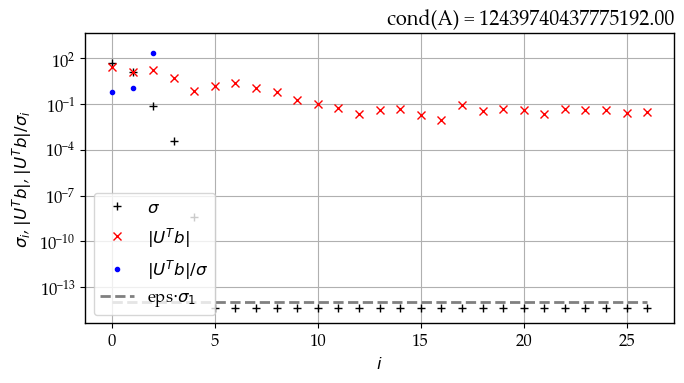

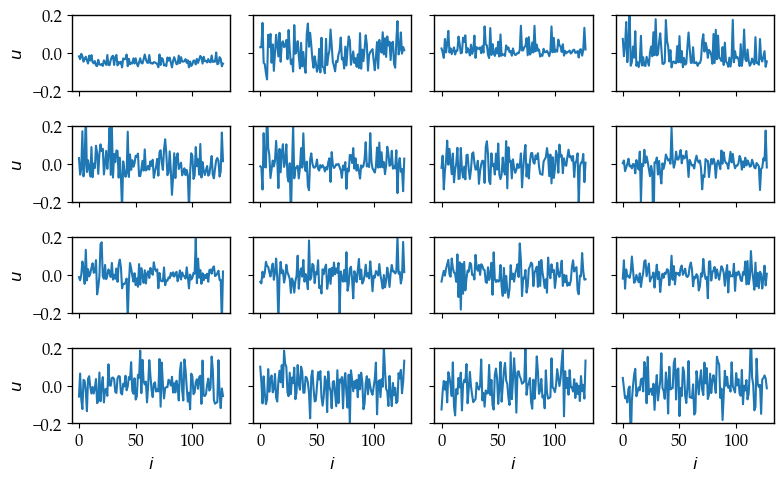

In [93]:
# SVD
[U,s,V] = lc.csvd(K)
print('shape da matriz U: {}'.format(U.shape))
print(r'shape da matriz Sigma: {}'.format(s.shape))
print(r'shape da matriz V: {}'.format(V.shape))
# plot Picard
lc.plot_picard(U,s,pres, figsize = (7, 4))
# plot column vectors
lc.plot_colvecs(np.real(U))

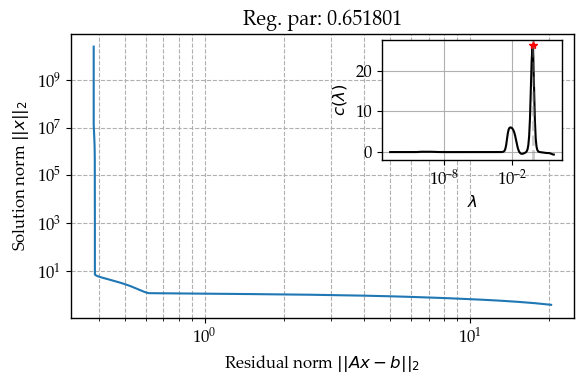

In [94]:
lam_lc = lc.l_curve(U, s, pres, plotit = True)
x_lc = lc.tikhonov(U, s, V, pres, lam_lc[0])

# Go pro - set up decompositions

We will go straight to the point of running the decompositions (varying the sampling strategy - for comparison). We can investigate the details along the way.

### Hyper-parameters

In [95]:
num_gauss_pts = 25
a = 0 # lower limit of integral (always zero usually - we left it open for tests)
b = 30 # upper limit of integral (truncation)

### Gauss-Legendre sampling

In [96]:
# Instatiate
decomp_qdt_gleg = Decomposition_QDT(p_mtx=field_nlr.pres_s[0], controls=field_nlr.controls,
    receivers=field_nlr.receivers, source_coord=field_nlr.sources.coord[0], quad_order=num_gauss_pts, a = a, b = b, 
    retraction = 0, image_source_on = True, regu_par = 'l-curve')

# Choose sampling scheme
decomp_qdt_gleg.gauss_legendre_sampling()

# Solve
decomp_qdt_gleg.pk_tikhonov(plot_l=False, method='Tikhonov')
#decomp_qdt_gleg.least_squares_pk()
# Reconstruct surface impedance
decomp_qdt_gleg.zs(Lx=0.1, n_x=21, Ly=0.1, n_y=21, theta=[0], avgZs=True);  # Zs

You choose L-curve to find optimal regularization parameter


Calculating Tikhonov inversion (for the Quadrature Method)...: 100%|██████████| 14/14 [00:00<00:00, 38.15it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 1559.51it/s]
Computing decomposition quality...: 100%|██████████| 14/14 [00:00<?, ?it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 539.87it/s]
Calculating the reconstructed particle velocity (uz_recon)...: 100%|██████████| 14/14 [00:00<00:00, 610.22it/s]
Calculating the surface impedance (Zs)...: 100%|██████████| 14/14 [00:00<00:00, 14041.19it/s]


### Gauss-Laguerre sampling

In [97]:
# Instatiate
decomp_qdt_glag = Decomposition_QDT(p_mtx=field_nlr.pres_s[0], controls=field_nlr.controls,
    receivers=field_nlr.receivers, source_coord=field_nlr.sources.coord[0], quad_order=num_gauss_pts, a = a, b = b, 
    retraction = 0, image_source_on = True, regu_par = 'l-curve')

# Choose sampling scheme
decomp_qdt_glag.gauss_laguerre_sampling()

# Solve
decomp_qdt_glag.pk_tikhonov(plot_l=False, method='Tikhonov')

# Reconstruct surface impedance
decomp_qdt_glag.zs(Lx=0.1, n_x=21, Ly=0.1, n_y=21, theta=[0], avgZs=True);  # Zs

You choose L-curve to find optimal regularization parameter


Calculating Tikhonov inversion (for the Quadrature Method)...: 100%|██████████| 14/14 [00:00<00:00, 43.07it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 1754.57it/s]
Computing decomposition quality...: 100%|██████████| 14/14 [00:00<00:00, 14017.73it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 401.05it/s]
Calculating the reconstructed particle velocity (uz_recon)...: 100%|██████████| 14/14 [00:00<00:00, 359.93it/s]
Calculating the surface impedance (Zs)...: 100%|██████████| 14/14 [00:00<?, ?it/s]


### Mid-point sampling

In [98]:
# Instatiate
decomp_qdt_mp = Decomposition_QDT(p_mtx=field_nlr.pres_s[0], controls=field_nlr.controls,
    receivers=field_nlr.receivers, source_coord=field_nlr.sources.coord[0], quad_order=num_gauss_pts, a = a, b = b, 
    retraction = 0, image_source_on = True, regu_par = 'l-curve')

# Choose sampling scheme
decomp_qdt_mp.mid_point_sampling()

# Solve
decomp_qdt_mp.pk_tikhonov(plot_l=False, method='Tikhonov')

# Reconstruct surface impedance
decomp_qdt_mp.zs(Lx=0.1, n_x=21, Ly=0.1, n_y=21, theta=[0], avgZs=True);  # Zs

You choose L-curve to find optimal regularization parameter


Calculating Tikhonov inversion (for the Quadrature Method)...: 100%|██████████| 14/14 [00:00<00:00, 40.81it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 1754.52it/s]
Computing decomposition quality...: 100%|██████████| 14/14 [00:00<00:00, 14047.91it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 519.96it/s]
Calculating the reconstructed particle velocity (uz_recon)...: 100%|██████████| 14/14 [00:00<00:00, 561.51it/s]
Calculating the surface impedance (Zs)...: 100%|██████████| 14/14 [00:00<00:00, 14034.48it/s]


## Let us investigate sampling schemes

- See the functions below
- plot:  weights vs. q
- plot Kernel vs. q

```python

def gauss_legendre_sampling(self,):
        """ Compute roots and weights of Gauss-Legendre quadrature
        """
        # Initialize variables
        self.roots, self.weights = roots_legendre(self.quad_order)  # roots and weights of G-L polynomials
        self.q = ((self.b - self.a) / 2) * self.roots + ((self.a + self.b) / 2)  # variable interval change
        
def gauss_laguerre_sampling(self,):
        """ Compute roots and weights of Gauss-Laguerre quadrature.
        
        The integral is from 0 to inf.
        """
        # Initialize variables
        self.q, self.weights = roots_laguerre(self.quad_order)  # roots and weights of G-L polynomials      
        self.compensation = np.exp(self.q)
        # Correct a and b so that (b-a)/2 = 1
        self.b = 2 
        self.a = 0
        
def mid_point_sampling(self,):
        """ Compute roots and weights for mid-point rule
        """
        # Initialize variables
        self.roots = np.linspace(-1 + 2/self.quad_order, 1 - 2/self.quad_order, self.quad_order) 
        self.weights = ((self.b-self.a)/self.quad_order) * np.ones(self.quad_order)
        self.q = ((self.b - self.a) / 2) * self.roots + ((self.a + self.b) / 2)  # variable interval change
```

### weights vs . q

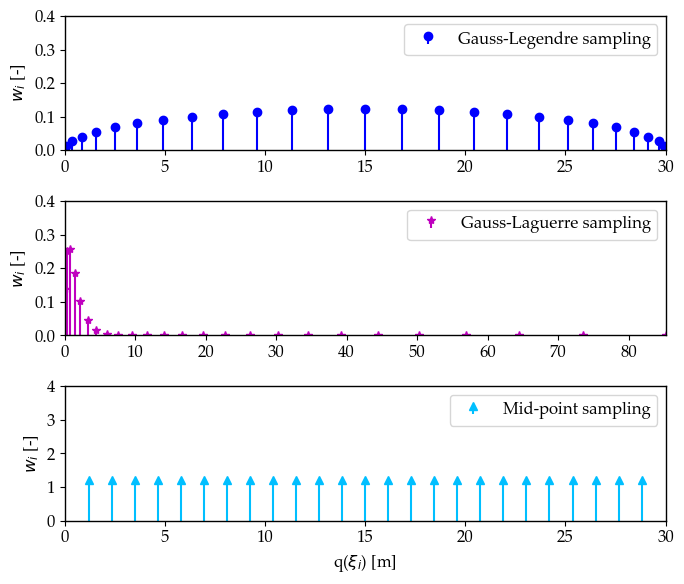

In [99]:
f, ax = plt.subplots(3, 1, figsize = (7,6), sharex = False)

ax[0].stem(decomp_qdt_gleg.q, decomp_qdt_gleg.weights, basefmt=" ", linefmt = 'b', markerfmt = 'ob',
           label = 'Gauss-Legendre sampling')
ax[0].legend()
#ax[0].set_title('Gauss-Legendre sampling')
ax[0].set_ylim((0, 0.4))
ax[0].set_xlim((a, b))


ax[1].stem(decomp_qdt_glag.q, decomp_qdt_glag.weights, basefmt=" ", linefmt = 'm', markerfmt = '*m',
           label = 'Gauss-Laguerre sampling')
#ax[1].set_title('Gauss-Laguerre sampling')
ax[1].legend()
ax[1].set_ylim((0, 0.4))
ax[1].set_xlim((a, decomp_qdt_glag.q[-1]))


markerline, stemlines, baseline = ax[2].stem(decomp_qdt_mp.q, decomp_qdt_mp.weights, basefmt=" ", linefmt = 'deepskyblue', 
           markerfmt = '^',
           label = 'Mid-point sampling')
markerline.set_markerfacecolor('deepskyblue')
markerline.set_markeredgecolor('deepskyblue')
#ax[2].set_title('Mid-point sampling')
ax[2].legend(loc = 'upper right')
ax[2].set_ylim((0, 4))
ax[2].set_xlim((a, b))
ax[2].set_xlabel(r'q($\xi_i$) [m]')
for ind in range(3):
    ax[ind].set_ylabel(r'$w_i$ [-]')
plt.tight_layout()
plt.savefig("quad_sampling.pdf", format = 'pdf')

### Kernel vs. q

```python
    def kernel_p(self, k0, rq):  # pressure kernel function
        iq = (np.exp(-1j * k0 * rq)) / rq
        return iq
```

In [100]:
freq = 100
k0 = 2*np.pi*freq/field_nlr.air.c0
_, _, _, _, rq, _ = decomp_qdt_gleg.get_rec_parameters(field_nlr.receivers)
iq_gleg = decomp_qdt_gleg.kernel_p(k0, rq)

_, _, _, _, rq, _ = decomp_qdt_glag.get_rec_parameters(field_nlr.receivers)
iq_glag = decomp_qdt_gleg.kernel_p(k0, rq)

_, _, _, _, rq, _ = decomp_qdt_mp.get_rec_parameters(field_nlr.receivers)
iq_mp = decomp_qdt_mp.kernel_p(k0, rq)

rec_id = 0

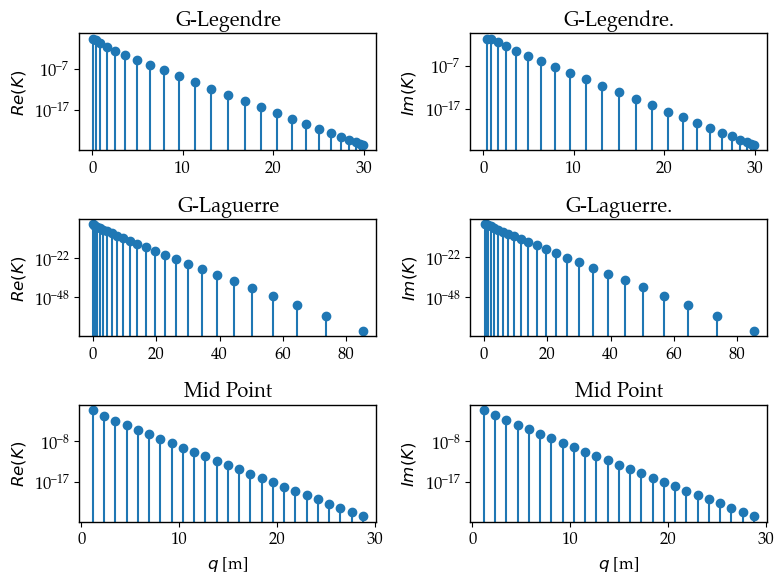

In [101]:
f, ax = plt.subplots(3, 2, figsize = (8,6), sharex = False)

ax[0,0].stem(decomp_qdt_gleg.q, np.real(iq_gleg[rec_id,:]), basefmt="")
ax[0,1].stem(decomp_qdt_gleg.q, np.imag(iq_gleg[rec_id,:]), basefmt="")

ax[1,0].stem(decomp_qdt_glag.q, np.real(iq_glag[rec_id,:]), basefmt="")
ax[1,1].stem(decomp_qdt_glag.q, np.imag(iq_glag[rec_id,:]), basefmt="")

ax[2,0].stem(decomp_qdt_mp.q, np.real(iq_mp[rec_id,:]), basefmt="")
ax[2,1].stem(decomp_qdt_mp.q, np.imag(iq_mp[rec_id,:]), basefmt="")
ax[0,0].set_title("G-Legendre")
ax[0,1].set_title("G-Legendre.")
ax[1,0].set_title("G-Laguerre")
ax[1,1].set_title("G-Laguerre.")
ax[2,0].set_title("Mid Point")
ax[2,1].set_title("Mid Point")
for row in range(3):
    for col in range(2):
        ax[row,col].set_yscale("log")
        ax[2,col].set_xlabel(r'$q$ [m]')
        ax[row,0].set_ylabel(r'$Re(K)$')
        ax[row,1].set_ylabel(r'$Im(K)$')
plt.tight_layout()

# Complex amplitude of monopoles

In [49]:
print('Shape of solution (all freqs): {}'.format(decomp_qdt_gleg.pk.shape))

Shape of solution (all freqs): (27, 14)


C:\Users\Cliente\AppData\Local\Temp\ipykernel_8372\4136412536.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['s', 'is', '','', '', '', '5', '','', '', '', '10', '','', '', '', '15', '','', '', '', '20',


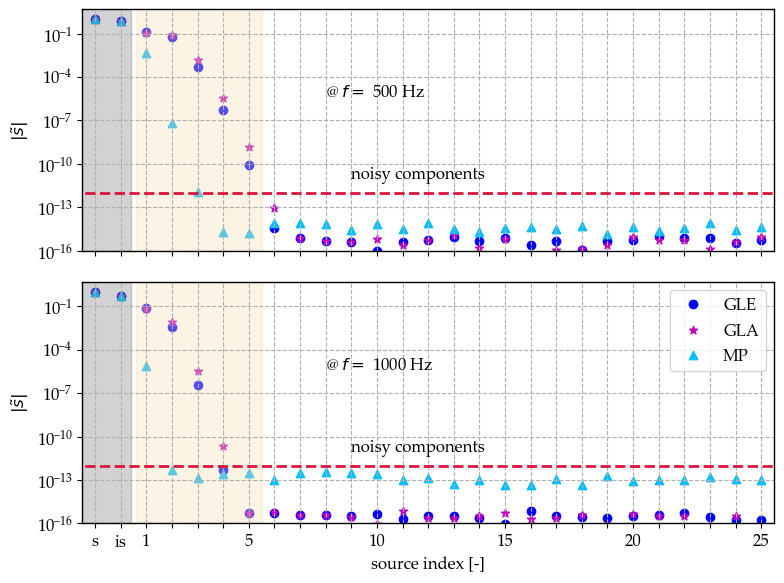

In [102]:
idfs = [7, 10]
#print("frequency {} Hz".format(dcism_gle_array0.controls.freq[idf]))

f, ax = plt.subplots(2, 1, figsize = (8,6), sharex = True)
#ax.scatter(1+np.arange(dcism_gle_array0.pk.shape[0]), 20*np.log10(np.abs(dcism_gle_array0.pk[:,idf])), color = 'b')
ax[0].scatter(1+np.arange(decomp_qdt_gleg.pk.shape[0]), np.abs(decomp_qdt_gleg.pk[:,idfs[0]]), color = 'b',
             marker = 'o')
ax[0].scatter(1+np.arange(decomp_qdt_gleg.pk.shape[0]), np.abs(decomp_qdt_glag.pk[:,idfs[0]]), color = 'm',
             marker = '*',)
ax[0].scatter(1+np.arange(decomp_qdt_gleg.pk.shape[0]), np.abs(decomp_qdt_mp.pk[:,idfs[0]]), color = 'deepskyblue',
             marker = '^',)
ax[0].set_yscale("log")
ax[0].set_xlim((0.5, decomp_qdt_gleg.pk.shape[0]+0.5))
ax[0].set_xticklabels(['s', 'is', '','', '', '', '5', '','', '', '', '10', '','', '', '', '15', '','', '', '', '20',
                   '','', '', '', '25'], rotation = 0)
ax[0].set_xticks(np.arange(1, 28))
ax[0].set_ylabel(r"$|\tilde{s}|$")
#ax[0].set_xlabel(r"source index [-]")
ax[0].grid(axis='both',linestyle = '--')
ax[0].annotate(r'@ $f = $ {:.0f} Hz'.format(decomp_qdt_gleg.controls.freq[idfs[0]]), xy=(10, 0.001), xytext=(10, 5e-6))
ax[0].axvspan(0.5, 2.4, color='grey', alpha=0.35)
ax[0].axvspan(2.6, 7.5, color='wheat', alpha=0.35)
ax[0].plot(1e-12 * np.ones(len(decomp_qdt_gleg.pk[:,idfs[0]])+2), '--', linewidth = 2.0, color = 'crimson')
ax[0].annotate(r'noisy components', xy=(10, 0.001), xytext=(11, 1e-11))
ax[0].set_ylim((1e-16, 5))

#ax.scatter(1+np.arange(dcism_gle_array0.pk.shape[0]), 20*np.log10(np.abs(dcism_gle_array0.pk[:,idf])), color = 'b')
ax[1].scatter(1+np.arange(decomp_qdt_gleg.pk.shape[0]), np.abs(decomp_qdt_gleg.pk[:,idfs[1]]), 
              color = 'b', marker = 'o', label = 'GLE')
ax[1].scatter(1+np.arange(decomp_qdt_gleg.pk.shape[0]), np.abs(decomp_qdt_glag.pk[:,idfs[1]]), 
              color = 'm', marker = '*', label = 'GLA')
ax[1].scatter(1+np.arange(decomp_qdt_gleg.pk.shape[0]), np.abs(decomp_qdt_mp.pk[:,idfs[1]]),
              color = 'deepskyblue', marker = '^', label = 'MP')
ax[1].set_yscale("log")
ax[1].set_xlim((0.5, decomp_qdt_gleg.pk.shape[0]+0.5))
ax[1].set_xticklabels(['s', 'is', '1','', '', '', '5', '','', '', '', '10', '','', '', '', '15', '','', '', '', '20',
                   '','', '', '', '25'], rotation = 0)
ax[1].set_xticks(np.arange(1, 28))
ax[1].set_ylabel(r"$|\tilde{s}|$")
ax[1].set_xlabel(r"source index [-]")
ax[1].grid(axis='both',linestyle = '--')
ax[1].annotate(r'@ $f = $ {:.0f} Hz'.format(decomp_qdt_gleg.controls.freq[idfs[1]]), xy=(10, 0.001), xytext=(10, 5e-6))
ax[1].legend()
ax[1].axvspan(0.5, 2.4, color='grey', alpha=0.35)
ax[1].axvspan(2.6, 7.5, color='wheat', alpha=0.35)
ax[1].plot(1e-12 * np.ones(len(decomp_qdt_gleg.pk[:,idfs[0]])+2), '--', linewidth = 2.0, color = 'crimson')
ax[1].annotate(r'noisy components', xy=(10, 0.001), xytext=(11, 1e-11))
ax[1].set_ylim((1e-16, 5));
plt.tight_layout()

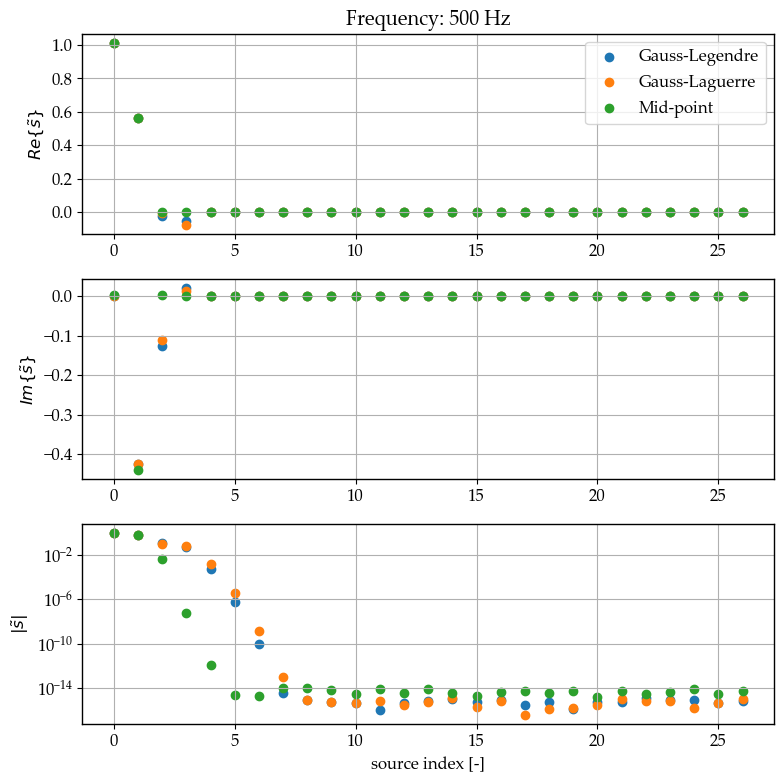

In [103]:
idf = 7
#print("frequency {} Hz".format(field_nlr.controls.freq[idf]))

f, ax = plt.subplots(3, 1, figsize = (8,8), sharex = False)

ax[0].scatter(np.arange(decomp_qdt_gleg.pk.shape[0]), np.real(decomp_qdt_gleg.pk[:,idf]), label = "Gauss-Legendre")
ax[0].scatter(np.arange(decomp_qdt_glag.pk.shape[0]), np.real(decomp_qdt_glag.pk[:,idf]), label = "Gauss-Laguerre")
ax[0].scatter(np.arange(decomp_qdt_mp.pk.shape[0]), np.real(decomp_qdt_mp.pk[:,idf]), label = "Mid-point")
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel(r"$Re\{\tilde{s}\}$")
ax[0].set_title("Frequency: {} Hz".format(field_nlr.controls.freq[idf]))

ax[1].scatter(np.arange(decomp_qdt_gleg.pk.shape[0]), np.imag(decomp_qdt_gleg.pk[:,idf]))
ax[1].scatter(np.arange(decomp_qdt_glag.pk.shape[0]), np.imag(decomp_qdt_glag.pk[:,idf]))
ax[1].scatter(np.arange(decomp_qdt_mp.pk.shape[0]), np.imag(decomp_qdt_mp.pk[:,idf]))
ax[1].set_ylabel(r"$Im\{\tilde{s}\}$")
ax[1].grid()

ax[2].scatter(np.arange(decomp_qdt_gleg.pk.shape[0]), np.abs(decomp_qdt_gleg.pk[:,idf]))
ax[2].scatter(np.arange(decomp_qdt_glag.pk.shape[0]), np.abs(decomp_qdt_glag.pk[:,idf]))
ax[2].scatter(np.arange(decomp_qdt_mp.pk.shape[0]), np.abs(decomp_qdt_mp.pk[:,idf]))
ax[2].set_yscale("log")
ax[2].set_ylabel(r"$|\tilde{s}|$")
ax[2].set_xlabel(r"source index [-]")
ax[2].grid()
plt.tight_layout()

# Sound field reconstruction

The sound pressure reconstruction is achieved with the following equation

$$
\tilde{\mathbf{p}}_{\mathrm{re}}=\mathbf{K}_{\mathrm{re}} \tilde{\mathbf{s}}
$$

where $\tilde{\mathbf{p}}_{\text {re }}\in \mathbb{C}^{W}$ is the reconstructed sound pressure vector at $W$ coordinates, and $\mathbf{K}_{\mathrm{re}}\in \mathbb{C}^{W \times (N+2) \ \text{or} \ (2)}$ is the reconstruction matrix containing the kernel evaluations. The particle velocity vector can be computed from Euler's equation, $\mathbf{u}=-\nabla p /(\mathrm{j} k \rho c)$. Thus

$$
\tilde{\mathbf{u}}_{\mathrm{re}}=\frac{-1}{\mathrm{j} k \rho c} \nabla \mathbf{K}_{\mathrm{re}} \tilde{\mathbf{s}}
$$

where $\nabla \mathbf{H}_{\mathrm{re}}\in \mathbb{C}^{W \times (N+2) \ \text{or} \ (2)}$ is the gradient of $\mathbf{K}_{\mathrm{re}}$. Each element in  $\nabla \mathbf{K}_{\mathrm{re}}$, in the $\hat{z}$ direction is

$$
\tilde{\mathbf{u}}_{\mathrm{re}_z}=\mp\frac{1}{\rho c}\frac{\text{e}^{-\text{j} k_0 |\textbf{r}_{s}- \textbf{r}_{q}|}}{|\textbf{r}_{s}- \textbf{r}_{q}|}\frac{h_s \pm z - \text{j} q}{|\textbf{r}_{s}- \textbf{r}_{q}|}\left(1+\frac{1}{\text{j}k_0|\textbf{r}_{s}- \textbf{r}_{q}|}\right)
$$

# Source / Image-source solution

In [104]:
decomp_mono = Decomposition_2M(p_mtx=field_nlr.pres_s[0], controls=field_nlr.controls,
                               receivers=field_nlr.receivers, source_coord=field_nlr.sources.coord[0], regu_par = 'l-curve')
decomp_mono.pk_tikhonov(plot_l=False, method='Tikhonov')
#decomp_mono.least_squares_pk()
decomp_mono.zs(Lx=0.1, n_x=21, Ly=0.1, n_y=21, theta=[0], avgZs=True); # Zs

You choose L-curve to find optimal regularization parameter


Calculating Tikhonov inversion (for the Quadrature Method)...:   0%|          | 0/14 [00:00<?, ?it/s]C:\Users\Cliente\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Calculating Tikhonov inversion (for the Quadrature Method)...: 100%|██████████| 14/14 [00:00<00:00, 45.87it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 7018.08it/s]
Computing decomposition quality...: 100%|██████████| 14/14 [00:00<00:00, 14034.48it/s]
Calculating the reconstructed pressure (p_recon)...: 100%|██████████| 14/14 [00:00<00:00, 3510.30it/s]
Calculating the reconstructed particle velocity (uz_recon)...: 100%|██████████| 14/14 [00:00<00

In [79]:
print('Shape of solution (all freqs): {}'.format(decomp_mono.pk.shape))
print('Solution values for a given frequency: {}'.format(decomp_mono.pk[:,9]))

Shape of solution (all freqs): (2, 15)
Solution values for a given frequency: [0.7011613 -0.06580473j 0.14089981-0.12530613j]


# Let's compare the NMSE of pressure and z-component of velocity

- The reference value comes from the Sommerfeld integral evaluation

In [105]:
# Compute NMSE of reconstructed data - Gauss-Legendre
nmse_qdt_ps_gleg = lc.nmse_freq(decomp_qdt_gleg.p_recon , field_nlr_zs.pres_s[0])
nmse_qdt_uzs_gleg = lc.nmse_freq(decomp_qdt_gleg.uz_recon , field_nlr_zs.uz_s[0])


# Compute NMSE of reconstructed data - Gauss-Laguerre
nmse_qdt_ps_glag = lc.nmse_freq(decomp_qdt_glag.p_recon , field_nlr_zs.pres_s[0])
nmse_qdt_uzs_glag = lc.nmse_freq(decomp_qdt_glag.uz_recon , field_nlr_zs.uz_s[0])


# Compute NMSE of reconstructed data - Mid-point
nmse_qdt_ps_mp = lc.nmse_freq(decomp_qdt_mp.p_recon , field_nlr_zs.pres_s[0])
nmse_qdt_uzs_mp = lc.nmse_freq(decomp_qdt_mp.uz_recon , field_nlr_zs.uz_s[0])

# Compute NMSE of reconstructed data - 2 Monopoles
nmse_2M_ps = lc.nmse_freq(decomp_mono.p_recon , field_nlr_zs.pres_s[0])
nmse_2M_uzs = lc.nmse_freq(decomp_mono.uz_recon , field_nlr_zs.uz_s[0])

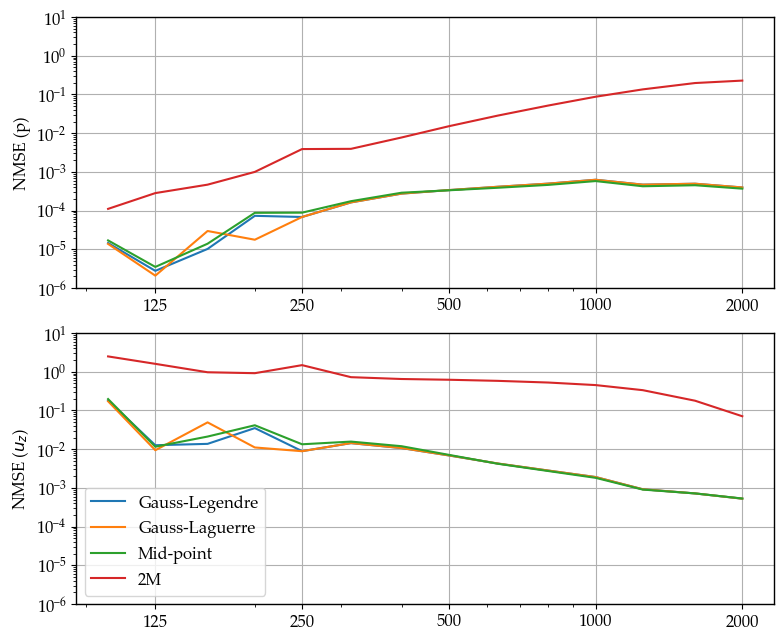

In [106]:
f, ax = plt.subplots(2, 1, figsize = (8,6.5), sharex = False)

ax[0].loglog(decomp_qdt_gleg.controls.freq, nmse_qdt_ps_gleg, label = "Gauss-Legendre")
ax[0].loglog(decomp_qdt_gleg.controls.freq, nmse_qdt_ps_glag, label = "Gauss-Laguerre")
ax[0].loglog(decomp_qdt_gleg.controls.freq, nmse_qdt_ps_mp, label = "Mid-point")
ax[0].loglog(decomp_qdt_gleg.controls.freq, nmse_2M_ps, label = "2M")
ax[0].grid()
ax[0].set_ylim((1e-6, 10))
ax[0].set_xticks(ticks = [125,250,500,1000,2000], labels = ['125','250','500','1000','2000'], rotation = 0)
ax[0].set_ylabel(r"NMSE (p)")

ax[1].loglog(decomp_qdt_gleg.controls.freq, nmse_qdt_uzs_gleg, label = "Gauss-Legendre")
ax[1].loglog(decomp_qdt_gleg.controls.freq, nmse_qdt_uzs_glag, label = "Gauss-Laguerre")
ax[1].loglog(decomp_qdt_gleg.controls.freq, nmse_qdt_uzs_mp, label = "Mid-point")
ax[1].loglog(decomp_qdt_gleg.controls.freq, nmse_2M_uzs, label = "2M")
ax[1].grid()
ax[1].legend()
ax[1].set_ylim((1e-6, 10))
ax[1].set_xticks(ticks = [125,250,500,1000,2000], labels = ['125','250','500','1000','2000'], rotation = 0)
ax[1].set_ylabel(r"NMSE ($u_z$)")
plt.tight_layout()

# Sound absorption

Now, we can do the decomposition with only two monopoles, as in Eq. ([3](#mjx-eqn-eq3)), for the sake of comparison. We want to compute the sound absorption coefficient of the sample. 

Note that this is **not equal** to the plane-wave sound absorption obtained from Miki's model. **This is because the incidence is spherical and not plane**. The sample reacts differently, and this is a physical effect. 

What shall happen as we increase the flow-resistivity?

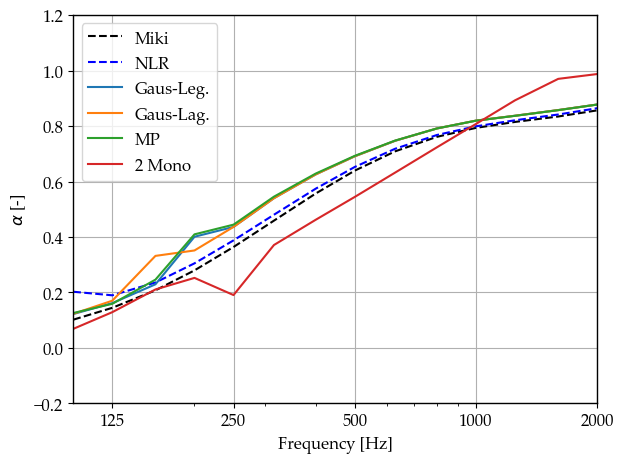

In [107]:
#%%
plt.figure()
plt.semilogx(field_nlr.controls.freq, field_nlr.material.alpha, '--k', label = 'Miki')
plt.semilogx(field_nlr.controls.freq, alpha_nlr, '--b', label = 'NLR')
plt.semilogx(decomp_qdt_gleg.controls.freq, decomp_qdt_gleg.alpha[0,:], label = 'Gaus-Leg.')
plt.semilogx(decomp_qdt_gleg.controls.freq, decomp_qdt_glag.alpha[0,:], label = 'Gaus-Lag.')
plt.semilogx(decomp_qdt_gleg.controls.freq, decomp_qdt_mp.alpha[0,:], label = 'MP')
plt.semilogx(decomp_mono.controls.freq, decomp_mono.alpha[0,:], label = '2 Mono')
plt.legend()
plt.xticks(ticks = [125,250,500,1000,2000,4000], labels = ['125','250','500','1000','2000', '4000'], rotation = 0)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\alpha$ [-]')
plt.grid()
plt.xlim((100, 2000))
plt.ylim((-0.2, 1.2))
plt.tight_layout()